In [172]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
import tensorflowjs as tfjs
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print(tf.config.list_physical_devices('GPU'))

[]


In [173]:
# Constants
NUM_GAMES = 10000
BATCH_SIZE = 32
LR = 1e-5

In [174]:
df = pd.read_csv('champions.csv')
def get_champ_vec(champ_name):
    arr = []
    row = df.loc[df['Champion'] == champ_name].iloc[0]
    for i in range(1, 16):
        if i == 7:
            if row[i] == 1:
                arr.append(1)
                arr.append(0)
                arr.append(0)
            elif row[i] == 2:
                arr.append(0)
                arr.append(1)
                arr.append(0)
            elif row[i] == 3:
                arr.append(0)
                arr.append(0)
                arr.append(1)
        else:
            arr.append(row[i] / 10)
    return arr

In [175]:
def process_match(match):
        champs = match.split(',')
        vec = []
        for i in range(10):
            champ_vec = get_champ_vec(champs[i])
            for e in champ_vec:
                vec.append(e)
        if champs[10] == 'true':
            vec.append(1)
        else:
            vec.append(0)
        return vec

In [176]:
def process_ds_element(x):
    return (tf.cast(x[:-1], 'float32'), tf.cast(x[-1], 'float32'))

In [177]:
def get_dataset():
    tmp = []
    with open('data/matches/grandmaster_training_data.txt', 'r') as f:
        matches = f.read().split('\n')
        global NUM_GAMES
        NUM_GAMES = min(len(matches), NUM_GAMES)
        for i in range(NUM_GAMES):
            try:
                tmp.append(process_match(matches[i]))
            except:
                NUM_GAMES-=1
    ds = tf.data.Dataset.from_tensor_slices(tmp)
    ds = ds.map(process_ds_element)
    ds = ds.cache()
    ds = ds.shuffle(NUM_GAMES)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    print(f'Using {NUM_GAMES} matches for training')
    return ds

In [178]:
ds = get_dataset()

Using 10000 matches for training


In [179]:
# Partition Dataset
train_size = int(len(ds)*0.7)
val_size = int(len(ds)*0.2)
test_size = len(ds) - (train_size + val_size)

train = ds.take(train_size)
val = ds.skip(train_size).take(val_size)
test = ds.skip(train_size+val_size).take(test_size)
print(train_size, val_size, test_size)

219 62 32


In [180]:
def create_model():
    model = keras.Sequential()
    model.add(layers.Dense(128, activation='relu', input_dim=170))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    return model

In [181]:
model = create_model()

In [182]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 128)               21888     
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dense_22 (Dense)            (None, 16)                1040      
                                                                 
 dense_23 (Dense)            (None, 1)                 17        
                                                                 
Total params: 31,201
Trainable params: 31,201
Non-trainable params: 0
_________________________________________________________________


In [183]:
loss = losses.BinaryCrossentropy(from_logits=True)
optimizer = optimizers.Adam(learning_rate=LR)
model.compile(loss=loss, optimizer=optimizer, metrics=[tf.metrics.BinaryAccuracy(threshold=0.0)])

In [184]:
history = model.fit(train, validation_data=val, epochs=1000)

Epoch 1/1000
219/219 [==============================] - 1s 1ms/step - loss: 0.6963 - binary_accuracy: 0.4937 - val_loss: 0.6956 - val_binary_accuracy: 0.5146
Epoch 2/1000
219/219 [==============================] - 0s 885us/step - loss: 0.6946 - binary_accuracy: 0.5093 - val_loss: 0.6922 - val_binary_accuracy: 0.5181
Epoch 3/1000
219/219 [==============================] - 0s 853us/step - loss: 0.6949 - binary_accuracy: 0.5067 - val_loss: 0.6950 - val_binary_accuracy: 0.5091
Epoch 4/1000
219/219 [==============================] - 0s 872us/step - loss: 0.6937 - binary_accuracy: 0.5097 - val_loss: 0.6955 - val_binary_accuracy: 0.4970
Epoch 5/1000
219/219 [==============================] - 0s 839us/step - loss: 0.6937 - binary_accuracy: 0.5083 - val_loss: 0.6940 - val_binary_accuracy: 0.5015
Epoch 6/1000
219/219 [==============================] - 0s 849us/step - loss: 0.6926 - binary_accuracy: 0.5151 - val_loss: 0.6909 - val_binary_accuracy: 0.5217
Epoch 7/1000
219/219 [====================

Epoch 52/1000
219/219 [==============================] - 0s 867us/step - loss: 0.6846 - binary_accuracy: 0.5604 - val_loss: 0.6844 - val_binary_accuracy: 0.5605
Epoch 53/1000
219/219 [==============================] - 0s 872us/step - loss: 0.6848 - binary_accuracy: 0.5576 - val_loss: 0.6824 - val_binary_accuracy: 0.5670
Epoch 54/1000
219/219 [==============================] - 0s 872us/step - loss: 0.6850 - binary_accuracy: 0.5534 - val_loss: 0.6853 - val_binary_accuracy: 0.5575
Epoch 55/1000
219/219 [==============================] - 0s 890us/step - loss: 0.6845 - binary_accuracy: 0.5575 - val_loss: 0.6842 - val_binary_accuracy: 0.5680
Epoch 56/1000
219/219 [==============================] - 0s 885us/step - loss: 0.6842 - binary_accuracy: 0.5606 - val_loss: 0.6856 - val_binary_accuracy: 0.5494
Epoch 57/1000
219/219 [==============================] - 0s 872us/step - loss: 0.6837 - binary_accuracy: 0.5588 - val_loss: 0.6863 - val_binary_accuracy: 0.5509
Epoch 58/1000
219/219 [===========

Epoch 103/1000
219/219 [==============================] - 0s 839us/step - loss: 0.6776 - binary_accuracy: 0.5743 - val_loss: 0.6786 - val_binary_accuracy: 0.5761
Epoch 104/1000
219/219 [==============================] - 0s 867us/step - loss: 0.6781 - binary_accuracy: 0.5796 - val_loss: 0.6753 - val_binary_accuracy: 0.5998
Epoch 105/1000
219/219 [==============================] - 0s 861us/step - loss: 0.6777 - binary_accuracy: 0.5751 - val_loss: 0.6720 - val_binary_accuracy: 0.5968
Epoch 106/1000
219/219 [==============================] - 0s 858us/step - loss: 0.6773 - binary_accuracy: 0.5839 - val_loss: 0.6774 - val_binary_accuracy: 0.5781
Epoch 107/1000
219/219 [==============================] - 0s 867us/step - loss: 0.6766 - binary_accuracy: 0.5853 - val_loss: 0.6811 - val_binary_accuracy: 0.5544
Epoch 108/1000
219/219 [==============================] - 0s 862us/step - loss: 0.6757 - binary_accuracy: 0.5856 - val_loss: 0.6776 - val_binary_accuracy: 0.5847
Epoch 109/1000
219/219 [====

219/219 [==============================] - 0s 890us/step - loss: 0.6689 - binary_accuracy: 0.6052 - val_loss: 0.6696 - val_binary_accuracy: 0.5943
Epoch 154/1000
219/219 [==============================] - 0s 876us/step - loss: 0.6676 - binary_accuracy: 0.6046 - val_loss: 0.6734 - val_binary_accuracy: 0.5963
Epoch 155/1000
219/219 [==============================] - 0s 894us/step - loss: 0.6676 - binary_accuracy: 0.6087 - val_loss: 0.6720 - val_binary_accuracy: 0.5943
Epoch 156/1000
219/219 [==============================] - 0s 867us/step - loss: 0.6680 - binary_accuracy: 0.6084 - val_loss: 0.6671 - val_binary_accuracy: 0.6079
Epoch 157/1000
219/219 [==============================] - 0s 894us/step - loss: 0.6672 - binary_accuracy: 0.6079 - val_loss: 0.6667 - val_binary_accuracy: 0.6043
Epoch 158/1000
219/219 [==============================] - 0s 908us/step - loss: 0.6668 - binary_accuracy: 0.6070 - val_loss: 0.6665 - val_binary_accuracy: 0.6043
Epoch 159/1000
219/219 [===================

Epoch 204/1000
219/219 [==============================] - 0s 908us/step - loss: 0.6583 - binary_accuracy: 0.6254 - val_loss: 0.6545 - val_binary_accuracy: 0.6436
Epoch 205/1000
219/219 [==============================] - 0s 904us/step - loss: 0.6588 - binary_accuracy: 0.6233 - val_loss: 0.6565 - val_binary_accuracy: 0.6346
Epoch 206/1000
219/219 [==============================] - 0s 899us/step - loss: 0.6575 - binary_accuracy: 0.6291 - val_loss: 0.6523 - val_binary_accuracy: 0.6346
Epoch 207/1000
219/219 [==============================] - 0s 885us/step - loss: 0.6588 - binary_accuracy: 0.6207 - val_loss: 0.6593 - val_binary_accuracy: 0.6210
Epoch 208/1000
219/219 [==============================] - 0s 908us/step - loss: 0.6565 - binary_accuracy: 0.6304 - val_loss: 0.6606 - val_binary_accuracy: 0.6240
Epoch 209/1000
219/219 [==============================] - 0s 931us/step - loss: 0.6564 - binary_accuracy: 0.6309 - val_loss: 0.6554 - val_binary_accuracy: 0.6401
Epoch 210/1000
219/219 [====

219/219 [==============================] - 0s 968us/step - loss: 0.6449 - binary_accuracy: 0.6484 - val_loss: 0.6459 - val_binary_accuracy: 0.6482
Epoch 255/1000
219/219 [==============================] - 0s 917us/step - loss: 0.6442 - binary_accuracy: 0.6531 - val_loss: 0.6432 - val_binary_accuracy: 0.6568
Epoch 256/1000
219/219 [==============================] - 0s 881us/step - loss: 0.6439 - binary_accuracy: 0.6485 - val_loss: 0.6444 - val_binary_accuracy: 0.6426
Epoch 257/1000
219/219 [==============================] - 0s 885us/step - loss: 0.6463 - binary_accuracy: 0.6433 - val_loss: 0.6405 - val_binary_accuracy: 0.6648
Epoch 258/1000
219/219 [==============================] - 0s 849us/step - loss: 0.6448 - binary_accuracy: 0.6463 - val_loss: 0.6447 - val_binary_accuracy: 0.6542
Epoch 259/1000
219/219 [==============================] - 0s 853us/step - loss: 0.6424 - binary_accuracy: 0.6515 - val_loss: 0.6424 - val_binary_accuracy: 0.6411
Epoch 260/1000
219/219 [===================

Epoch 305/1000
219/219 [==============================] - 0s 899us/step - loss: 0.6300 - binary_accuracy: 0.6715 - val_loss: 0.6276 - val_binary_accuracy: 0.6673
Epoch 306/1000
219/219 [==============================] - 0s 881us/step - loss: 0.6298 - binary_accuracy: 0.6672 - val_loss: 0.6254 - val_binary_accuracy: 0.6784
Epoch 307/1000
219/219 [==============================] - 0s 899us/step - loss: 0.6303 - binary_accuracy: 0.6675 - val_loss: 0.6265 - val_binary_accuracy: 0.6749
Epoch 308/1000
219/219 [==============================] - 0s 885us/step - loss: 0.6289 - binary_accuracy: 0.6701 - val_loss: 0.6292 - val_binary_accuracy: 0.6658
Epoch 309/1000
219/219 [==============================] - 0s 885us/step - loss: 0.6282 - binary_accuracy: 0.6701 - val_loss: 0.6308 - val_binary_accuracy: 0.6628
Epoch 310/1000
219/219 [==============================] - 0s 894us/step - loss: 0.6276 - binary_accuracy: 0.6694 - val_loss: 0.6262 - val_binary_accuracy: 0.6638
Epoch 311/1000
219/219 [====

219/219 [==============================] - 0s 936us/step - loss: 0.6116 - binary_accuracy: 0.6882 - val_loss: 0.6149 - val_binary_accuracy: 0.6658
Epoch 356/1000
219/219 [==============================] - 0s 890us/step - loss: 0.6122 - binary_accuracy: 0.6828 - val_loss: 0.6048 - val_binary_accuracy: 0.7092
Epoch 357/1000
219/219 [==============================] - 0s 905us/step - loss: 0.6109 - binary_accuracy: 0.6852 - val_loss: 0.6133 - val_binary_accuracy: 0.6815
Epoch 358/1000
219/219 [==============================] - 0s 885us/step - loss: 0.6122 - binary_accuracy: 0.6846 - val_loss: 0.6079 - val_binary_accuracy: 0.6860
Epoch 359/1000
219/219 [==============================] - 0s 913us/step - loss: 0.6100 - binary_accuracy: 0.6886 - val_loss: 0.6055 - val_binary_accuracy: 0.6850
Epoch 360/1000
219/219 [==============================] - 0s 899us/step - loss: 0.6116 - binary_accuracy: 0.6889 - val_loss: 0.6113 - val_binary_accuracy: 0.6865
Epoch 361/1000
219/219 [===================

Epoch 406/1000
219/219 [==============================] - 0s 890us/step - loss: 0.5893 - binary_accuracy: 0.7096 - val_loss: 0.5846 - val_binary_accuracy: 0.7228
Epoch 407/1000
219/219 [==============================] - 0s 904us/step - loss: 0.5919 - binary_accuracy: 0.7048 - val_loss: 0.5898 - val_binary_accuracy: 0.7067
Epoch 408/1000
219/219 [==============================] - 0s 885us/step - loss: 0.5917 - binary_accuracy: 0.7048 - val_loss: 0.5856 - val_binary_accuracy: 0.7132
Epoch 409/1000
219/219 [==============================] - 0s 885us/step - loss: 0.5917 - binary_accuracy: 0.7015 - val_loss: 0.5979 - val_binary_accuracy: 0.6860
Epoch 410/1000
219/219 [==============================] - 0s 890us/step - loss: 0.5892 - binary_accuracy: 0.7031 - val_loss: 0.5931 - val_binary_accuracy: 0.7077
Epoch 411/1000
219/219 [==============================] - 0s 894us/step - loss: 0.5890 - binary_accuracy: 0.7056 - val_loss: 0.5897 - val_binary_accuracy: 0.7067
Epoch 412/1000
219/219 [====

219/219 [==============================] - 0s 1ms/step - loss: 0.5713 - binary_accuracy: 0.7175 - val_loss: 0.5768 - val_binary_accuracy: 0.7167
Epoch 457/1000
219/219 [==============================] - 0s 936us/step - loss: 0.5711 - binary_accuracy: 0.7182 - val_loss: 0.5760 - val_binary_accuracy: 0.7122
Epoch 458/1000
219/219 [==============================] - 0s 1ms/step - loss: 0.5678 - binary_accuracy: 0.7257 - val_loss: 0.5623 - val_binary_accuracy: 0.7182
Epoch 459/1000
219/219 [==============================] - 0s 1ms/step - loss: 0.5680 - binary_accuracy: 0.7207 - val_loss: 0.5693 - val_binary_accuracy: 0.7172
Epoch 460/1000
219/219 [==============================] - 0s 1ms/step - loss: 0.5674 - binary_accuracy: 0.7249 - val_loss: 0.5750 - val_binary_accuracy: 0.7198
Epoch 461/1000
219/219 [==============================] - 0s 945us/step - loss: 0.5669 - binary_accuracy: 0.7273 - val_loss: 0.5781 - val_binary_accuracy: 0.7061
Epoch 462/1000
219/219 [===========================

Epoch 507/1000
219/219 [==============================] - 0s 890us/step - loss: 0.5467 - binary_accuracy: 0.7374 - val_loss: 0.5451 - val_binary_accuracy: 0.7455
Epoch 508/1000
219/219 [==============================] - 0s 931us/step - loss: 0.5503 - binary_accuracy: 0.7356 - val_loss: 0.5548 - val_binary_accuracy: 0.7288
Epoch 509/1000
219/219 [==============================] - 0s 885us/step - loss: 0.5454 - binary_accuracy: 0.7379 - val_loss: 0.5603 - val_binary_accuracy: 0.7213
Epoch 510/1000
219/219 [==============================] - 0s 904us/step - loss: 0.5447 - binary_accuracy: 0.7412 - val_loss: 0.5347 - val_binary_accuracy: 0.7535
Epoch 511/1000
219/219 [==============================] - 0s 894us/step - loss: 0.5452 - binary_accuracy: 0.7372 - val_loss: 0.5422 - val_binary_accuracy: 0.7500
Epoch 512/1000
219/219 [==============================] - 0s 881us/step - loss: 0.5451 - binary_accuracy: 0.7397 - val_loss: 0.5445 - val_binary_accuracy: 0.7455
Epoch 513/1000
219/219 [====

219/219 [==============================] - 0s 1ms/step - loss: 0.5270 - binary_accuracy: 0.7496 - val_loss: 0.5238 - val_binary_accuracy: 0.7576
Epoch 558/1000
219/219 [==============================] - 0s 899us/step - loss: 0.5239 - binary_accuracy: 0.7517 - val_loss: 0.5284 - val_binary_accuracy: 0.7500
Epoch 559/1000
219/219 [==============================] - 0s 945us/step - loss: 0.5227 - binary_accuracy: 0.7527 - val_loss: 0.5231 - val_binary_accuracy: 0.7520
Epoch 560/1000
219/219 [==============================] - 0s 931us/step - loss: 0.5229 - binary_accuracy: 0.7577 - val_loss: 0.5235 - val_binary_accuracy: 0.7525
Epoch 561/1000
219/219 [==============================] - 0s 917us/step - loss: 0.5216 - binary_accuracy: 0.7578 - val_loss: 0.5177 - val_binary_accuracy: 0.7661
Epoch 562/1000
219/219 [==============================] - 0s 950us/step - loss: 0.5224 - binary_accuracy: 0.7526 - val_loss: 0.5290 - val_binary_accuracy: 0.7545
Epoch 563/1000
219/219 [=====================

Epoch 608/1000
219/219 [==============================] - 0s 895us/step - loss: 0.5002 - binary_accuracy: 0.7701 - val_loss: 0.5061 - val_binary_accuracy: 0.7671
Epoch 609/1000
219/219 [==============================] - 0s 899us/step - loss: 0.5026 - binary_accuracy: 0.7626 - val_loss: 0.5049 - val_binary_accuracy: 0.7626
Epoch 610/1000
219/219 [==============================] - 0s 894us/step - loss: 0.4993 - binary_accuracy: 0.7676 - val_loss: 0.5016 - val_binary_accuracy: 0.7576
Epoch 611/1000
219/219 [==============================] - 0s 881us/step - loss: 0.5023 - binary_accuracy: 0.7647 - val_loss: 0.5033 - val_binary_accuracy: 0.7616
Epoch 612/1000
219/219 [==============================] - 0s 894us/step - loss: 0.4985 - binary_accuracy: 0.7708 - val_loss: 0.4966 - val_binary_accuracy: 0.7646
Epoch 613/1000
219/219 [==============================] - 0s 904us/step - loss: 0.4963 - binary_accuracy: 0.7725 - val_loss: 0.4945 - val_binary_accuracy: 0.7797
Epoch 614/1000
219/219 [====

219/219 [==============================] - 0s 885us/step - loss: 0.4751 - binary_accuracy: 0.7871 - val_loss: 0.4656 - val_binary_accuracy: 0.7964
Epoch 659/1000
219/219 [==============================] - 0s 876us/step - loss: 0.4755 - binary_accuracy: 0.7810 - val_loss: 0.4661 - val_binary_accuracy: 0.7989
Epoch 660/1000
219/219 [==============================] - 0s 894us/step - loss: 0.4706 - binary_accuracy: 0.7901 - val_loss: 0.4712 - val_binary_accuracy: 0.7908
Epoch 661/1000
219/219 [==============================] - 0s 899us/step - loss: 0.4742 - binary_accuracy: 0.7815 - val_loss: 0.4742 - val_binary_accuracy: 0.7833
Epoch 662/1000
219/219 [==============================] - 0s 917us/step - loss: 0.4746 - binary_accuracy: 0.7851 - val_loss: 0.4710 - val_binary_accuracy: 0.7878
Epoch 663/1000
219/219 [==============================] - 0s 899us/step - loss: 0.4685 - binary_accuracy: 0.7925 - val_loss: 0.4702 - val_binary_accuracy: 0.7833
Epoch 664/1000
219/219 [===================

Epoch 709/1000
219/219 [==============================] - 0s 890us/step - loss: 0.4506 - binary_accuracy: 0.7999 - val_loss: 0.4461 - val_binary_accuracy: 0.8009
Epoch 710/1000
219/219 [==============================] - 0s 885us/step - loss: 0.4515 - binary_accuracy: 0.8009 - val_loss: 0.4487 - val_binary_accuracy: 0.7964
Epoch 711/1000
219/219 [==============================] - 0s 890us/step - loss: 0.4483 - binary_accuracy: 0.8065 - val_loss: 0.4560 - val_binary_accuracy: 0.7928
Epoch 712/1000
219/219 [==============================] - 0s 908us/step - loss: 0.4473 - binary_accuracy: 0.8032 - val_loss: 0.4597 - val_binary_accuracy: 0.8014
Epoch 713/1000
219/219 [==============================] - 0s 913us/step - loss: 0.4483 - binary_accuracy: 0.8064 - val_loss: 0.4482 - val_binary_accuracy: 0.7989
Epoch 714/1000
219/219 [==============================] - 0s 899us/step - loss: 0.4471 - binary_accuracy: 0.8064 - val_loss: 0.4462 - val_binary_accuracy: 0.8034
Epoch 715/1000
219/219 [====

219/219 [==============================] - 0s 890us/step - loss: 0.4260 - binary_accuracy: 0.8181 - val_loss: 0.4252 - val_binary_accuracy: 0.8206
Epoch 760/1000
219/219 [==============================] - 0s 913us/step - loss: 0.4266 - binary_accuracy: 0.8185 - val_loss: 0.4405 - val_binary_accuracy: 0.8049
Epoch 761/1000
219/219 [==============================] - 0s 904us/step - loss: 0.4223 - binary_accuracy: 0.8191 - val_loss: 0.4145 - val_binary_accuracy: 0.8266
Epoch 762/1000
219/219 [==============================] - 0s 908us/step - loss: 0.4256 - binary_accuracy: 0.8209 - val_loss: 0.4306 - val_binary_accuracy: 0.8145
Epoch 763/1000
219/219 [==============================] - 0s 913us/step - loss: 0.4230 - binary_accuracy: 0.8219 - val_loss: 0.4114 - val_binary_accuracy: 0.8357
Epoch 764/1000
219/219 [==============================] - 0s 959us/step - loss: 0.4234 - binary_accuracy: 0.8165 - val_loss: 0.4164 - val_binary_accuracy: 0.8226
Epoch 765/1000
219/219 [===================

Epoch 810/1000
219/219 [==============================] - 0s 890us/step - loss: 0.4013 - binary_accuracy: 0.8338 - val_loss: 0.3926 - val_binary_accuracy: 0.8402
Epoch 811/1000
219/219 [==============================] - 0s 899us/step - loss: 0.4018 - binary_accuracy: 0.8295 - val_loss: 0.3993 - val_binary_accuracy: 0.8306
Epoch 812/1000
219/219 [==============================] - 0s 894us/step - loss: 0.3989 - binary_accuracy: 0.8356 - val_loss: 0.3983 - val_binary_accuracy: 0.8337
Epoch 813/1000
219/219 [==============================] - 0s 908us/step - loss: 0.3989 - binary_accuracy: 0.8342 - val_loss: 0.3871 - val_binary_accuracy: 0.8533
Epoch 814/1000
219/219 [==============================] - 0s 890us/step - loss: 0.4008 - binary_accuracy: 0.8338 - val_loss: 0.3968 - val_binary_accuracy: 0.8367
Epoch 815/1000
219/219 [==============================] - 0s 890us/step - loss: 0.3960 - binary_accuracy: 0.8393 - val_loss: 0.4033 - val_binary_accuracy: 0.8276
Epoch 816/1000
219/219 [====

219/219 [==============================] - 0s 890us/step - loss: 0.3748 - binary_accuracy: 0.8470 - val_loss: 0.3825 - val_binary_accuracy: 0.8432
Epoch 861/1000
219/219 [==============================] - 0s 913us/step - loss: 0.3779 - binary_accuracy: 0.8432 - val_loss: 0.3699 - val_binary_accuracy: 0.8468
Epoch 862/1000
219/219 [==============================] - 0s 899us/step - loss: 0.3726 - binary_accuracy: 0.8503 - val_loss: 0.3755 - val_binary_accuracy: 0.8458
Epoch 863/1000
219/219 [==============================] - 0s 894us/step - loss: 0.3728 - binary_accuracy: 0.8502 - val_loss: 0.3800 - val_binary_accuracy: 0.8438
Epoch 864/1000
219/219 [==============================] - 0s 913us/step - loss: 0.3712 - binary_accuracy: 0.8485 - val_loss: 0.3815 - val_binary_accuracy: 0.8458
Epoch 865/1000
219/219 [==============================] - 0s 908us/step - loss: 0.3721 - binary_accuracy: 0.8507 - val_loss: 0.3554 - val_binary_accuracy: 0.8644
Epoch 866/1000
219/219 [===================

Epoch 911/1000
219/219 [==============================] - 0s 876us/step - loss: 0.3453 - binary_accuracy: 0.8656 - val_loss: 0.3520 - val_binary_accuracy: 0.8629
Epoch 912/1000
219/219 [==============================] - 0s 908us/step - loss: 0.3483 - binary_accuracy: 0.8646 - val_loss: 0.3453 - val_binary_accuracy: 0.8690
Epoch 913/1000
219/219 [==============================] - 0s 899us/step - loss: 0.3488 - binary_accuracy: 0.8663 - val_loss: 0.3477 - val_binary_accuracy: 0.8659
Epoch 914/1000
219/219 [==============================] - 0s 899us/step - loss: 0.3493 - binary_accuracy: 0.8639 - val_loss: 0.3466 - val_binary_accuracy: 0.8705
Epoch 915/1000
219/219 [==============================] - 0s 913us/step - loss: 0.3472 - binary_accuracy: 0.8669 - val_loss: 0.3498 - val_binary_accuracy: 0.8579
Epoch 916/1000
219/219 [==============================] - 0s 904us/step - loss: 0.3481 - binary_accuracy: 0.8640 - val_loss: 0.3436 - val_binary_accuracy: 0.8669
Epoch 917/1000
219/219 [====

219/219 [==============================] - 0s 935us/step - loss: 0.3239 - binary_accuracy: 0.8813 - val_loss: 0.3193 - val_binary_accuracy: 0.8821
Epoch 962/1000
219/219 [==============================] - 0s 894us/step - loss: 0.3252 - binary_accuracy: 0.8760 - val_loss: 0.3318 - val_binary_accuracy: 0.8745
Epoch 963/1000
219/219 [==============================] - 0s 885us/step - loss: 0.3208 - binary_accuracy: 0.8783 - val_loss: 0.3273 - val_binary_accuracy: 0.8805
Epoch 964/1000
219/219 [==============================] - 0s 885us/step - loss: 0.3266 - binary_accuracy: 0.8757 - val_loss: 0.3214 - val_binary_accuracy: 0.8841
Epoch 965/1000
219/219 [==============================] - 0s 913us/step - loss: 0.3170 - binary_accuracy: 0.8841 - val_loss: 0.3190 - val_binary_accuracy: 0.8861
Epoch 966/1000
219/219 [==============================] - 0s 893us/step - loss: 0.3237 - binary_accuracy: 0.8780 - val_loss: 0.3312 - val_binary_accuracy: 0.8725
Epoch 967/1000
219/219 [===================

In [185]:
history_dict = history.history

In [186]:
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

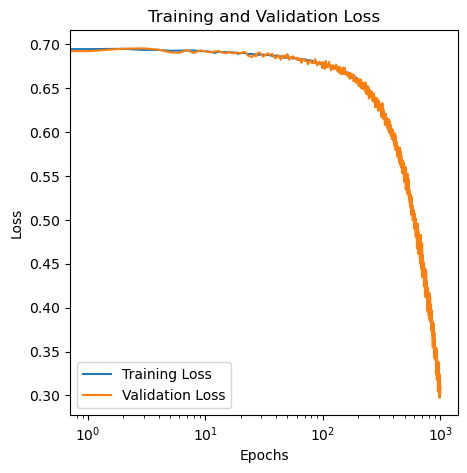

In [187]:
plt.figure(figsize=(5, 5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
plt.show()

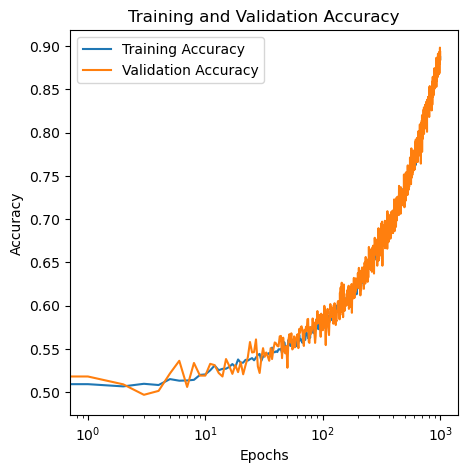

In [188]:
plt.figure(figsize=(5, 5))
plt.plot(history_dict['binary_accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.xscale('log')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [190]:
loss, accuracy = model.evaluate(test)
print('Loss:', loss)
print('Accuracy:', accuracy)

32/32 [==============================] - 0s 449us/step - loss: 0.3131 - binary_accuracy: 0.8849
Loss: 0.31312933564186096
Accuracy: 0.8849206566810608


In [121]:
# Save the model
export_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Activation('sigmoid')
])

In [122]:
def test_model(champ_names):
    Xs = []
    for name in champ_names:
        Xs += get_champ_vec(name)
    Xs = tf.constant([Xs])
    return export_model(Xs)

In [125]:
test_model(['Fiora', 'XinZhao', 'Cassiopeia', 'Jhin', 'Heimerdinger', 'Jayce', 'Khazix', 'Lissandra', 'Varus', 'Karma'])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9525021]], dtype=float32)>

In [36]:
tfjs.converters.save_keras_model(export_model, 'winpredictor/public/models/master')